# Evaluation Unigram Baseline Classifier

Meta information removed for blind review.

In [1]:
import pandas as pd

### Read Training and Test Data Set
Source: https://germeval2021toxic.github.io/SharedTask/

#### Train Data Set

In [2]:
train_df = pd.read_csv("https://raw.githubusercontent.com/germeval2021toxic/SharedTask/main/Data%20Sets/GermEval21_TrainData.csv")
#If parsing from Github, use url from raw data.

In [3]:
train_df.head()

,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,1,Ziemlich traurig diese Kommentare zu lesen. Ih...,0,0,0
1,2,"Sag ich doch, wir befeuern den Klimawandel. Ra...",0,1,1
2,3,"Schublade auf, Schublade zu. Zu mehr Denkleist...",1,0,0
3,4,Dummerweise haben wir in der EU und in der USA...,0,0,1
4,5,"""So lange Gewinnmaximierung Vorrang hat, wird ...",0,0,0


In [4]:
len(train_df)

3244

In [5]:
train_df = train_df[["comment_text", "Sub1_Toxic"]]

In [6]:
train_df.Sub1_Toxic.value_counts()

0    2122
1    1122
Name: Sub1_Toxic, dtype: int64

#### Test Data Test

In [7]:
test_df = pd.read_csv("https://raw.githubusercontent.com/germeval2021toxic/SharedTask/main/Data%20Sets/GermEval21_TestData.csv")

In [8]:
test_df.head()

,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...,1,1,0
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die...",0,1,1
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...,0,1,1
3,3248,"Als jemand, der im real existierenden Sozialis...",1,0,0
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...,1,0,0


In [9]:
len(test_df)

944

In [10]:
test_df = test_df[["comment_text", "Sub1_Toxic"]]

In [11]:
test_df.Sub1_Toxic.value_counts()

0    594
1    350
Name: Sub1_Toxic, dtype: int64

### Preprocessing Training and Test Data

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [13]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [14]:
stopwords_nltk = list(set(stopwords.words('german')))

In [15]:
stopwords_nltk.sort()

In [16]:
stopwords_nltk[-10:] #Last 10 enties of the stopword list

['wollte',
 'während',
 'würde',
 'würden',
 'zu',
 'zum',
 'zur',
 'zwar',
 'zwischen',
 'über']

In [17]:
len(stopwords_nltk)

232

In [18]:
vec = TfidfVectorizer(stop_words=stopwords_nltk,
                      max_df=0.90, #ignore terms that appear in more than 90% of the documents
                      min_df=0.01 #ignore terms that appear in less than 1% of the documents
                     ) 

#### Oversampling


In [19]:
from imblearn.over_sampling import SMOTE #Smote Oversampling Algorithm

In [20]:
X_train = train_df["comment_text"]
y_train = train_df["Sub1_Toxic"]

In [21]:
X_train_vec = vec.fit_transform(X_train)

In [22]:
smt = SMOTE(random_state=42)

In [23]:
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train_vec, y_train)

In [24]:
X_train_SMOTE #Resampled matrix

<4244x146 sparse matrix of type '<class 'numpy.float64'>'
	with 16254 stored elements in Compressed Sparse Row format>

In [25]:
X_train_vec #Not resampled matrix

<3244x146 sparse matrix of type '<class 'numpy.float64'>'
	with 11604 stored elements in Compressed Sparse Row format>

#### Train Classifer

In [26]:
from sklearn.svm import SVC #Support Vector Machine Classifier

In [27]:
model = SVC()

In [28]:
model.fit(X_train_SMOTE, y_train_SMOTE) #Train on resampled training data

SVC()

### Apply and Evaluate Classifier

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

In [30]:
y_test = test_df["Sub1_Toxic"]
X_test = test_df["comment_text"]

In [31]:
y_pred = model.predict(vec.transform(X_test))

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       594
           1       0.40      0.35      0.37       350

    accuracy                           0.57       944
   macro avg       0.52      0.52      0.52       944
weighted avg       0.56      0.57      0.56       944



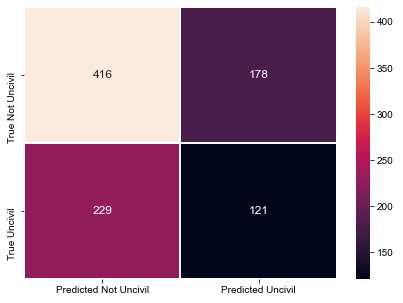

In [33]:
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array,index=["True Not Uncivil", "True Uncivil"],
                  columns = ["Predicted Not Uncivil", "Predicted Uncivil"])
plt.figure(figsize = (7,5)
)

fig = sn.heatmap(df_cm, 
                 annot=True,
                 annot_kws={"fontsize":12},
                # cmap="crest",
                 cbar=True, 
                 linewidth=0.9, 
                 linecolor="white",
                 fmt='g')
sn.set(font_scale=1.8)
figure = fig.get_figure()    
figure.savefig('svm_cm.pdf', dpi=400)

#### Alternative Pipeline

In [34]:
from imblearn.pipeline import make_pipeline
pipeline = make_pipeline(smt, model)

In [35]:
pipeline.fit(X_train_vec, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('svc', SVC())])

In [36]:
y_pred_pipe = pipeline.predict(vec.transform(X_test))

In [37]:
print(classification_report(y_test, y_pred_pipe))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       594
           1       0.40      0.35      0.37       350

    accuracy                           0.57       944
   macro avg       0.52      0.52      0.52       944
weighted avg       0.56      0.57      0.56       944



#### Results without SMOTE

In [38]:
model.fit(X_train_vec, y_train)

SVC()

In [39]:
y_pred_imb= model.predict(vec.transform(X_test))

In [40]:
print(classification_report(y_test, y_pred_imb))

              precision    recall  f1-score   support

           0       0.63      0.95      0.76       594
           1       0.43      0.07      0.11       350

    accuracy                           0.62       944
   macro avg       0.53      0.51      0.44       944
weighted avg       0.56      0.62      0.52       944



### Hyper-Parameter Tuning via Grid Search

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
SVC().get_params().keys()
#You can also look up the hyper parameters for your classifier in the documentation.
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

#Introduction to hyper-parameters: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [46]:
parameters = {'kernel': ('linear', 'rbf','poly') , 
              'C':[5, 10, 100],
              'gamma': [1,0.1,0.01,0.001]}

In [53]:
%%time
grid = GridSearchCV(SVC() , parameters , refit=True, scoring="f1_macro", cv=10) 
#Using the refit-method, the model will be fitted on the data again using the optimal combination of parameters.
#We aim to optimize towards macro f1 score.
grid.fit(X_train_SMOTE,
         y_train_SMOTE)

Wall time: 8min 13s


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [5, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ('linear', 'rbf', 'poly')},
             scoring='f1_macro')

In [54]:
print(grid.best_params_)

{'C': 5, 'gamma': 1, 'kernel': 'rbf'}


In [55]:
y_pred_grid = grid.predict(vec.transform(X_test))

#### Final Results

In [56]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       594
           1       0.40      0.39      0.39       350

    accuracy                           0.56       944
   macro avg       0.52      0.52      0.52       944
weighted avg       0.55      0.56      0.55       944



In [48]:
import seaborn as sn
import matplotlib.pyplot as plt

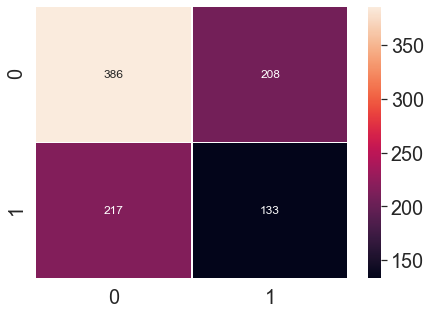

In [49]:
array2 = confusion_matrix(y_test, y_pred_grid)
df_cm2 = pd.DataFrame(array2,index=None)
plt.figure(figsize = (7,5))
fig2 = sn.heatmap(df_cm2, 
                 annot=True,
                 annot_kws={"fontsize":12},
                 #cmap="crest",
                 cbar=True, 
                 linewidth=0.5, 
                 linecolor="white",
                 fmt='g')
sn.set(font_scale=1.8)
figure2 = fig2.get_figure()    
figure2.savefig('svm_cm_gridsearch.pdf', dpi=400)